Notebook by Lauren Wielgus. I pulled out the code needed for a network analysis, and wrote functions to perform network analyses by player and by group. 

In [2]:
#load relevant libraries
import pandas as pd
from pandas import DataFrame 
from pandas import Series
import json,csv
#import delorean
import matplotlib.pyplot as plt
#this allows your graphs to show up in the nb, super important
%matplotlib inline 
import datetime
from datetime import datetime
import matplotlib.dates as mdates
from collections import defaultdict 
import numpy as np
import math

#import this to make network graphs
import networkx as nx
#helps you make prettier graphs
import seaborn as sns 

In [3]:
#make a dictionary for all the group names
groupDict = {
    0.0: 'white-group',
    1.0: 'red-group',
    2.0: 'green-group',
    3.0: 'pink-group',
    4.0: 'blue-group',
    5.0: 'yellow-group',
    6.0: 'orange-group',
    7.0: 'turquoise-group',
    8.0: 'fuschia-group'
}

In [4]:
#open data file
#this data is from the first 2 games of the day
infilename = "events-feb-4-two-plays.json"
infile = open(infilename,'rb')
#read each line of json 
mydata = []
for line in infile:
    mydata.append(json.loads(line))

#make a dataframe from the data
myData = DataFrame(mydata)

#open data file
#this data is from the afternoon game
infilename = "events-feb-4-last.json"
infile = open(infilename,'rb')
#read each line of json 
mydata2 = []
for line in infile:
    mydata2.append(json.loads(line))

#make a dataframe from the data
myData2 = DataFrame(mydata2)

Games in the data:
- myData has game 51092 (1st game) and game 2416 (2nd game)
- myData2 has game 1730 (3rd game)

In [5]:
#read in a list of all the players from the workshop for the different games
playerKey2 = pd.read_csv('usernamelinks-2_withHeader.csv')
playerKey1 = pd.read_csv('usernamelinks-1_withHeader.csv')
playerKey=pd.concat([playerKey1,playerKey2])

In [6]:
playerKey.head()

,group,groupName,playerName,gameCode,playerID
0,7,turquoise-group,nathanholbert,1730,7Qja4Pdv7SnB5Su9x
1,4,blue-group,frieda-reichsman,1730,3Eh5BmKSJCvkWSbFu
2,0,white-group,kevinm,1730,RtaSqPRjYYtSjGAbX
3,1,red-group,magy,1730,XG4RPdHyZ8RycCQQn
4,6,orange-group,marleenvilleroy,1730,SAwW4Cwoq9c9fAKmB


In [7]:
#function to make a network graph from a specific game
#playerKey is a dataframe with the following cols: group,groupName,playerName,gameCode,playerID 
def makePlayerNetwork(mydf,myGame,playerKey,minTrades):
    #first grab data from a specific game, only trade responses that were completed
    myKey = 'TradeRequestResponded'

    isGame = mydf['gameCode'] == myGame
    isKey = mydf['key'] == myKey
    isResponse = mydf['response'] == 1

    df = mydf[isKey & isGame & isResponse]
    
    #now need to figure out all the trades that occurred
    #first initialize an empty array
    #cols 0 and 1 are the players, and col 2 is the number of trades between those players
    trades = []
    #initialize the first entry
    trades.append([df.iloc[0]['requesterName'],df.iloc[0]['recipientName'],1])

    #loop through all the completed trades and determine who traded with who, and how often
    for i in range(1,len(df)):
        reqName = df.iloc[i]['requesterName']
        recvName = df.iloc[i]['recipientName']
    
        foundPair = False
    
        #search through trades and if pairing already exists, increment n
        #need to test both orderings
        for k in range(len(trades)):
            if trades[k][0]==reqName and trades[k][1]==recvName:
                trades[k][2] = trades[k][2] + 1
                foundPair = True
                break
            if trades[k][0]==recvName and trades[k][1]==reqName:
                trades[k][2] = trades[k][2] + 1
                foundPair = True
                break
            
        #else if trade pairing hasn't been found, then append to the list
        if foundPair == False:
            trades.append([reqName,recvName,1])
    
    #make a network graph
    G=nx.Graph()

    #make a new array to store connections above the minTrades threshold
    newTrades = []

    #use trades array to make a network graph, only adding pairings above the minTrades threshold
    for i in range(len(trades)):
        if trades[i][2]>=minTrades:
            newTrades.append(trades[i])
            G.add_edge(trades[i][0],trades[i][1],weight=trades[i][2])
    
    # labels
    allEdges = [(u,v) for (u,v,d) in newTrades]
    allWidths = [(d) for (u,v,d) in newTrades]

    #the following code makes a network plot; more trades are represented as thicker lines between nodes
    #fixed_nodes = fixed_positions.keys()
    #pos = nx.spring_layout(G,pos=fixed_positions, fixed = fixed_nodes)
    pos = nx.spring_layout(G,k=6,iterations=20) # k varies from 0-1; bigger value for k means more space beween nodes

    #sets colors of the nodes based on the group names
    #if you leave out node_color argument, default node color is red
    colorVals = list()
    for node in G.nodes():
        #find which group this player is in
        #grab row of the playerKey that matches player name
        myPlayerKey = playerKey[playerKey['gameCode']==int(myGame)]
        group = myPlayerKey.loc[myPlayerKey.playerName==node]['groupName'].iloc[0]
        colorVals.append(group.replace("-group", ""))

    nx.draw_networkx_nodes(G,pos,node_size=500,node_color=colorVals)
    nx.draw_networkx_edges(G,pos,edgelist=allEdges,width=allWidths)

    # pos_higher is a dict of label positions that have been shifted in the y-direction by y_off
    #makes the labels offset from the circles
    pos_higher = {}
    y_off = 0.1  # offset on the y axis
    for k, v in pos.items():
        pos_higher[k] = (v[0], v[1]+y_off)
    #nx.draw_networkx_labels(G,pos,font_size=10,font_family='sans-serif') #this line centers the labels on the nodes
    nx.draw_networkx_labels(G,pos_higher,font_size=12,font_family='sans-serif') #this positions the labels slightly above the nodes

    #make edge labels, skipping those edges with 0 connections
    edgeLabels = dict()
    for i in range(len(allEdges)):
        if allWidths[i] != 0:
            edgeLabels[allEdges[i]]=allWidths[i]
        
    #add labels, and place the label on the edge using label_pos, if label_pos=.5 then label is centered
    nx.draw_networkx_edge_labels(G,pos, edgeLabels, font_size=12,label_pos=0.5)

    plt.axis('off')
    # plt.savefig("weighted_graph_feb1.png") # save as png
    plt.tight_layout()
    myTitle = 'Game '+str(myGame)+': Completed Trades Between Players (nTrades >= '+str(minTrades)+')'
    plt.title(myTitle,size=14)
    plt.show() # display
    

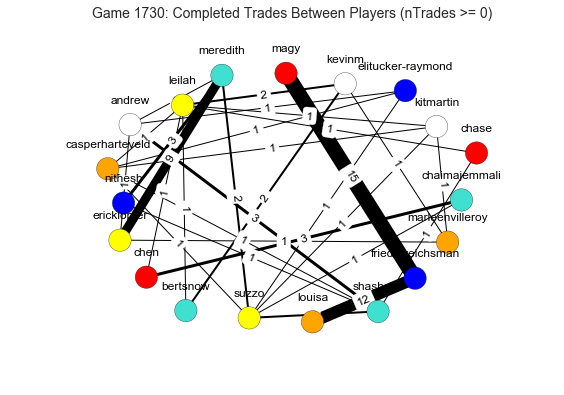

In [8]:
makePlayerNetwork(myData2,'1730',playerKey,0)

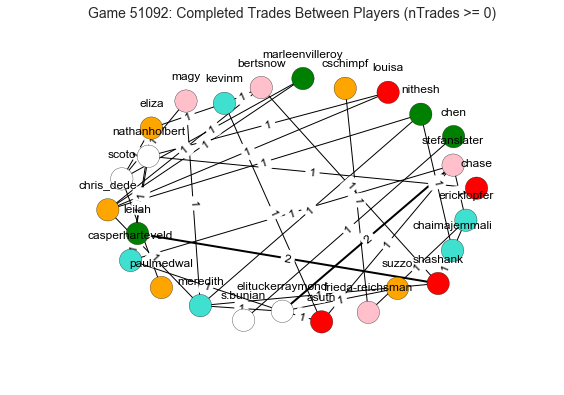

In [9]:
makePlayerNetwork(myData,'51092',playerKey,0)

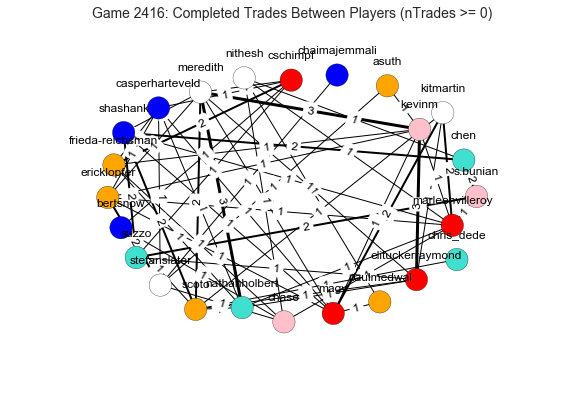

In [10]:
makePlayerNetwork(myData,'2416',playerKey,0)

In [11]:
#function to make a network graph from a specific game
#groupDict is defined at the top of the notebook
def makeGroupNetwork(mydf,myGame,groupDict,minTrades):
    #first grab data from a specific game, only trade responses that were completed
    myKey = 'TradeRequestResponded'

    isGame = mydf['gameCode'] == myGame
    isKey = mydf['key'] == myKey
    isResponse = mydf['response'] == 1

    df = mydf[isKey & isGame & isResponse]
    
    if len(df)==0:
        print 'No completed trades found'
        return
    #now need to figure out all the trades that occurred
    #first initialize an empty array
    #cols 0 and 1 are the groups, and col 2 is the number of trades between those players
    trades = []
    #initialize the first entry
    trades.append([groupDict[df.iloc[0]['requesterGroup']],groupDict[df.iloc[0]['recipientGroup']],1])

    #loop through all the completed trades and determine who traded with who, and how often
    for i in range(1,len(df)):
        reqName = groupDict[df.iloc[i]['requesterGroup']]
        recvName = groupDict[df.iloc[i]['recipientGroup']]
    
        foundPair = False
    
        #search through trades and if pairing already exists, increment n
        #need to test both orderings
        for k in range(len(trades)):
            if trades[k][0]==reqName and trades[k][1]==recvName:
                trades[k][2] = trades[k][2] + 1
                foundPair = True
                break
            if trades[k][0]==recvName and trades[k][1]==reqName:
                trades[k][2] = trades[k][2] + 1
                foundPair = True
                break
            
        #else if trade pairing hasn't been found, then append to the list
        if foundPair == False:
            trades.append([reqName,recvName,1])
    
    #make a network graph
    G=nx.Graph()

    #make a new array to store connections above the minTrades threshold
    newTrades = []

    #use trades array to make a network graph, only adding pairings above the minTrades threshold
    for i in range(len(trades)):
        if trades[i][2]>=minTrades:
            newTrades.append(trades[i])
            G.add_edge(trades[i][0],trades[i][1],weight=trades[i][2])
    
    # labels
    allEdges = [(u,v) for (u,v,d) in newTrades]
    allWidths = [(d) for (u,v,d) in newTrades]

    #the following code makes a network plot; more trades are represented as thicker lines between nodes
    #fixed_nodes = fixed_positions.keys()
    #pos = nx.spring_layout(G,pos=fixed_positions, fixed = fixed_nodes)
    pos = nx.spring_layout(G,k=6,iterations=20) # k varies from 0-1; bigger value for k means more space beween nodes

    #sets colors of the nodes based on the group names
    #if you leave out node_color argument, default node color is red
    colorVals = list()
    for node in G.nodes():
        group = node
        colorVals.append(group.replace("-group", ""))

    nx.draw_networkx_nodes(G,pos,node_size=500,node_color=colorVals)
    nx.draw_networkx_edges(G,pos,edgelist=allEdges,width=allWidths)

    # pos_higher is a dict of label positions that have been shifted in the y-direction by y_off
    #makes the labels offset from the circles
    pos_higher = {}
    y_off = 0.1  # offset on the y axis
    for k, v in pos.items():
        pos_higher[k] = (v[0], v[1]+y_off)
    #nx.draw_networkx_labels(G,pos,font_size=10,font_family='sans-serif') #this line centers the labels on the nodes
    nx.draw_networkx_labels(G,pos_higher,font_size=12,font_family='sans-serif') #this positions the labels slightly above the nodes

    #make edge labels, skipping those edges with 0 connections
    edgeLabels = dict()
    for i in range(len(allEdges)):
        if allWidths[i] != 0:
            edgeLabels[allEdges[i]]=allWidths[i]
        
    #add labels, and place the label on the edge using label_pos, if label_pos=.5 then label is centered
    nx.draw_networkx_edge_labels(G,pos, edgeLabels, font_size=12,label_pos=0.5)

    plt.axis('off')
    # plt.savefig("weighted_graph_feb1.png") # save as png
    plt.tight_layout()
    myTitle = 'Game '+str(myGame)+': Completed Trades Between Groups (nTrades >= '+str(minTrades)+')'
    plt.title(myTitle,size=14)
    #plt.show() # display
    
    

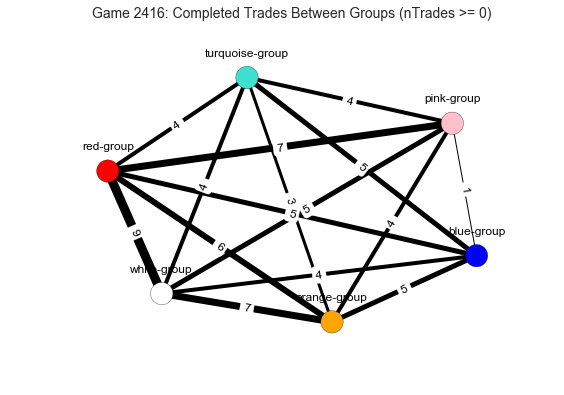

In [12]:
makeGroupNetwork(myData,'2416',groupDict,0)
#could save fig here if desired
plt.show()

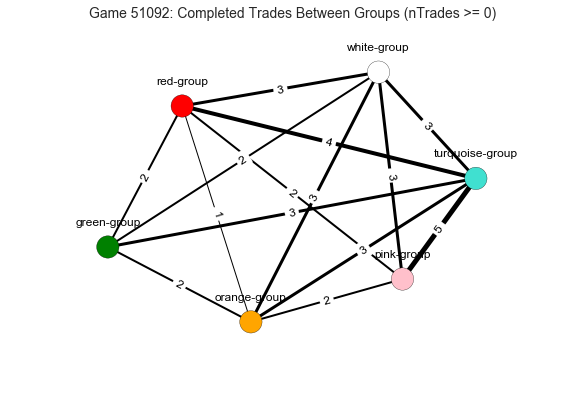

In [13]:
makeGroupNetwork(myData,'51092',groupDict,0)
#could save fig here if desired
plt.show()

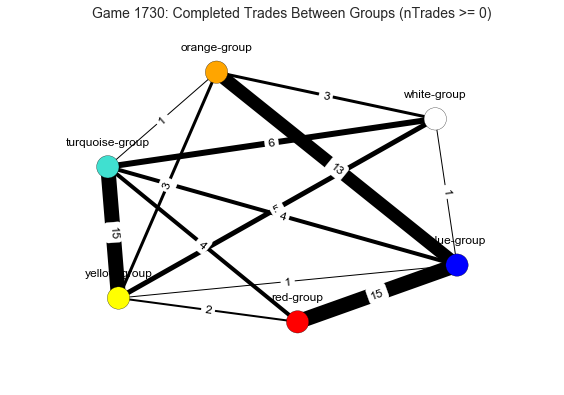

In [14]:
makeGroupNetwork(myData2,'1730',groupDict,0)
#could save fig here if desired
plt.show()

In [15]:
#let's see how trades between groups changed over time in the game
#need to get a list of years in the game, filter trades by year, and make a network plot for each year

myGame = '1730'
df = myData2

dfYear = df[df.key=='GameYearIncrease']
maxYear = int(max(dfYear['newYearValue']))
minYear = int(min(dfYear['newYearValue'])-1)
yearList = range(minYear,maxYear+1)


    

In [16]:
yearList

[2253, 2254, 2255, 2256, 2257, 2258, 2259]

In [17]:
tempYearList = [2253]

No completed trades found


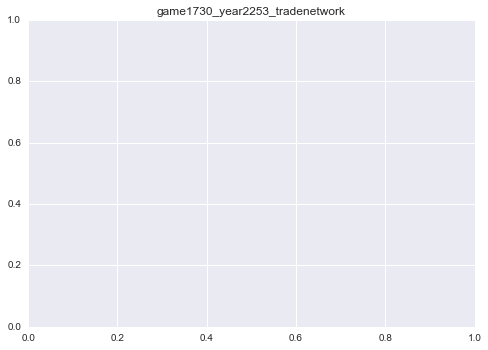

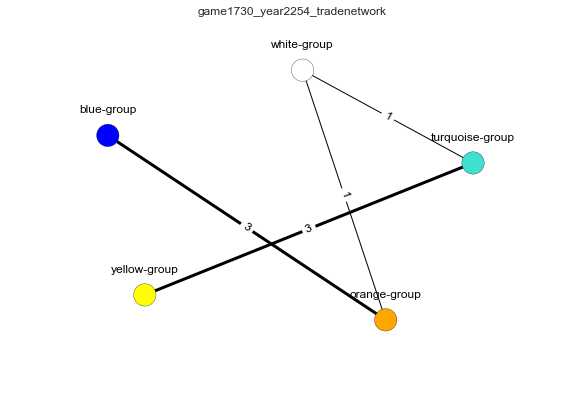

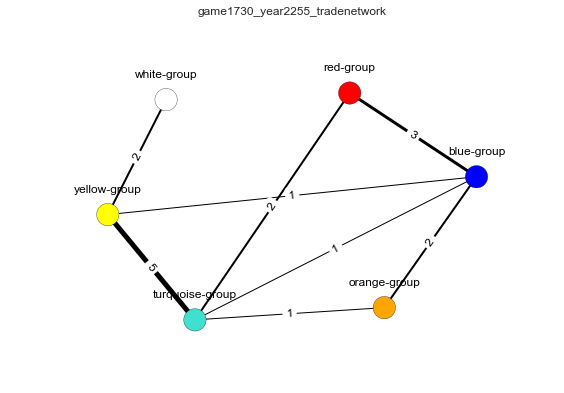

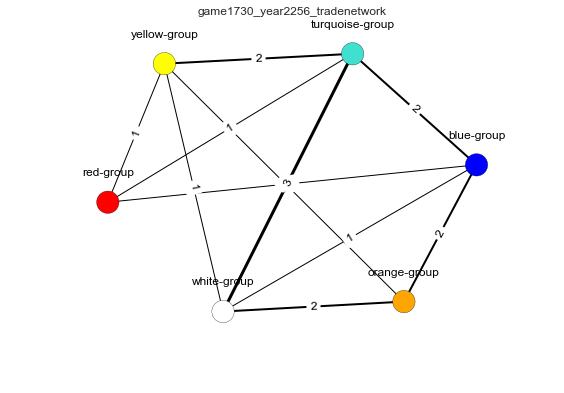

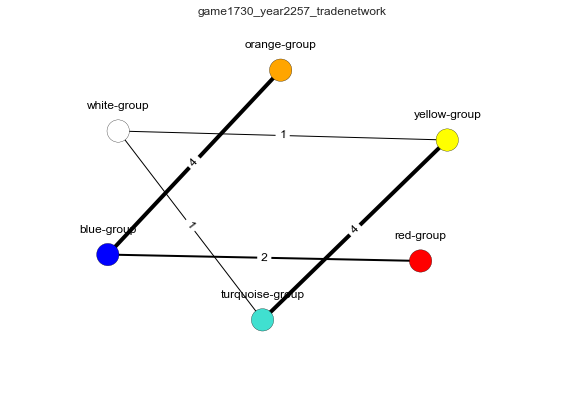

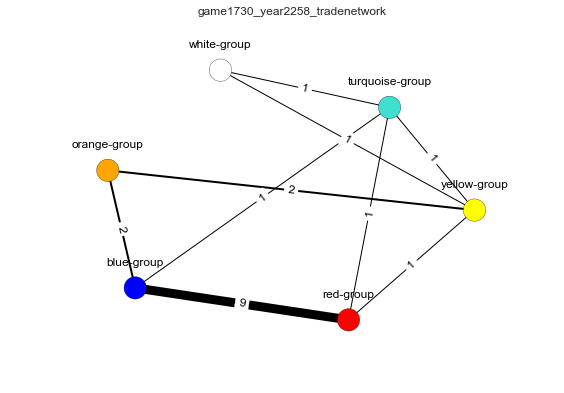

No completed trades found


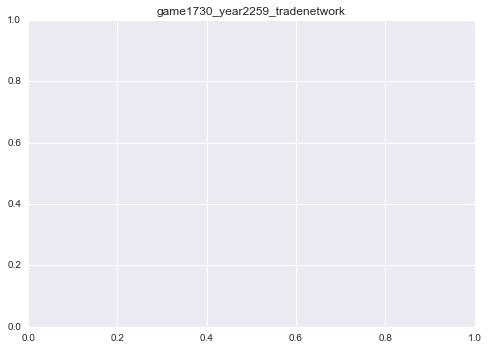

In [18]:
#now loop through all the years and make plots
for y in yearList:
    curDF = df[df.year==y]
    makeGroupNetwork(curDF,myGame,groupDict,0)
    myTitle = 'game'+myGame+'_year'+str(y)+'_tradenetwork'
    myFile = myTitle+'.png'
    plt.title(myTitle) #make a new title that specifies the year
    plt.savefig(myFile) # save as png
    plt.show()
    